# Visualize Feature

In this notebook we will see how images are transformed stage-by-stage to a feature vector and how feature becomes more informative for classification. 

## Data flow in MobileNet v2

| Input          | Shape      | -> Transform           | Semantic |
|----------------|------------|------------------------|----------|
| Image          | arbitrary  | Data pipeline          | Low      |
| Input Tensor   | 224x224x3  | conv 2d                |          |
|                | 112x112x32 | MobileNet stage 1      |          |
| Stage 0        | 112x112x16 | MobileNet stage 2      |          |
| Stage 1        | 56x56x24   | MobileNet stage 3      |          |
| Stage 2        | 28x28x32   | MobileNet stage 4      |          |
| Stage 3        | 14x14x64   | MobileNet stage 5      |          |
| Stage 4        | 14x14x96   | MobileNet stage 6      |          |
| Stage 5        | 7x7x160    | MobileNet stage 7      |          |
| Stage 6        | 7x7x320    | conv 2d                |          |
| Stage 7        | 7x7x1280   | Global Average Pooling |          |
| Feature Vector | 1x1x1280   | Classifier             |          |
| Prob           | 1000       |                        | High     |


## How image is transformed trough stages

### Build a Model

Credit to Zihao: https://github.com/TommyZihao/MMClassification_Tutorials

`wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip`

In [1]:
import torch
from mmcls.models import ImageClassifier, GlobalAveragePooling, MobileNetV2, LinearClsHead

model = ImageClassifier(
    ## NOTE here we extract features from 4 stages
    backbone=dict(type='MobileNetV2', widen_factor=1.0, out_indices=(1, 3, 5, 7)),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=30,
        in_channels=1280),
)

# IMPORTANT
model.eval()

model.cuda()
model.load_state_dict(torch.load('fruit30_mmcls.pth')["state_dict"])

<All keys matched successfully>

### Load a image

In [2]:
from PIL import Image

image = Image.open('banana.png').convert('RGB')
# image = Image.open('data/fruit30_split/train/草莓/1.jpg').convert('RGB')

In [3]:
image.size

(393, 403)

### Transform a image

In [4]:
from torchvision.transforms import Resize, CenterCrop, Compose, ToTensor, Normalize

tv_transform = Compose([
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ])

In [5]:
input = tv_transform(image).unsqueeze(0)

In [6]:
input.shape

torch.Size([1, 3, 224, 224])

### Extract Features

In [7]:
with torch.no_grad():
    bb_feats = model.extract_feat(input.cuda(), stage='backbone')
    neck_feats = model.extract_feat(input.cuda(), stage='neck')

In [8]:
for f in bb_feats:
    print(f.shape)

torch.Size([1, 24, 56, 56])
torch.Size([1, 64, 14, 14])
torch.Size([1, 160, 7, 7])
torch.Size([1, 1280, 7, 7])


In [9]:
for f in neck_feats:
    print(f.shape)

torch.Size([1, 24])
torch.Size([1, 64])
torch.Size([1, 160])
torch.Size([1, 1280])


### Visualize Feature maps

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import lru_cache

@lru_cache
def vis_feature(feat_map):
    n,c,h,w = feat_map.shape
    # t = PCA(n_components=3)
    t = TSNE(n_components=3)

    out = t.fit_transform(feat_map.cpu().numpy().reshape(c,-1).transpose())
    
    vis = out.reshape(h, w, 3)
    vis -= vis.min(axis=0).min(axis=0)
    vis /= vis.max(axis=0).max(axis=0)
    
    return vis

C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wa

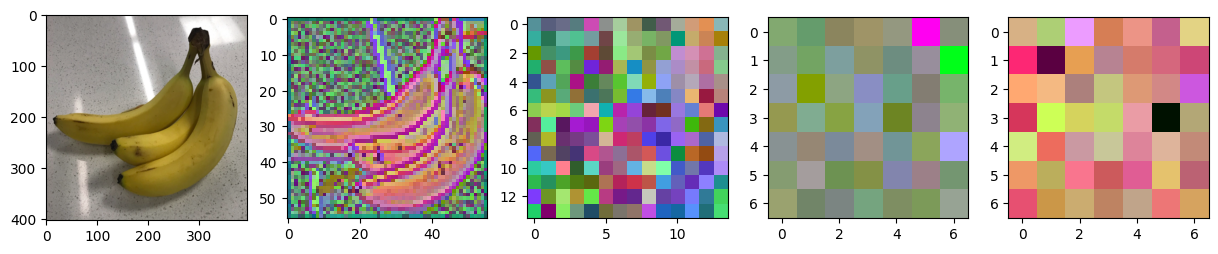

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,3))

plt.subplot(1,len(bb_feats)+1,1)
plt.imshow(image)

for i in range(2, len(bb_feats)+2):
    plt.subplot(1, len(bb_feats)+1, i)
    plt.imshow(vis_feature(bb_feats[i-2]))
    
plt.show()

We see feature maps becomes *abstract* as stage increases. 
Raw pixels are transferred to features.

## How feature becomes more semantic

We will see features are gradually grouped in features spaces as stage becomes higher.

### Build a fruit dataset

Credit to Zihao: https://github.com/TommyZihao/MMClassification_Tutorials

`wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip`

In [12]:
from torchvision.datasets import ImageFolder

tv_transform = Compose([
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ])

dataset = ImageFolder(
    r"data/fruit30_split/train",
    transform=tv_transform)

Show a Image

In [13]:
dataset[0][0].shape

torch.Size([3, 224, 224])

### Extract Features

In [14]:
all_feats = [[] for stage in range(len(bb_feats)+1)]
labels = []

for i in range(0, len(dataset), 10):
    input = dataset[i][0]
    label = dataset[i][1]
    
    with torch.no_grad():
        feats = model.extract_feat(input.unsqueeze(0).cuda(), stage='neck')
    
    all_feats[0].append(input.flatten())
    
    for f, l in zip(feats, all_feats[1:]):
        l.append(f.flatten())
        
    labels.append(label)
    
all_feats = [torch.stack(a) for a in all_feats]

In [15]:
for a in all_feats:
    print(a.shape)

torch.Size([438, 150528])
torch.Size([438, 24])
torch.Size([438, 64])
torch.Size([438, 160])
torch.Size([438, 1280])


### Group Features in Feature Space

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

reduce = []
for feats in all_feats:
    out = tsne.fit_transform(feats.cpu().numpy())
    reduce.append(out)    

C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wa

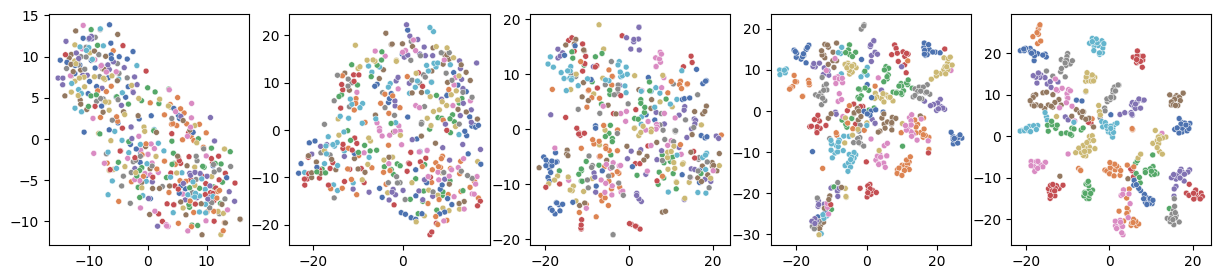

In [18]:
from seaborn import scatterplot
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))

for i, out in enumerate(reduce):
    plt.subplot(1,len(reduce),i+1)
    ax = scatterplot(x=out[:,0], y=out[:,1], hue=labels, palette='deep', legend = False, size=1)

We see samples in feature spaces becomes more separable as stage increases. 
Ot in other words, feature becomes more *semantic* as stage increase.